In [45]:
import numpy as np
from sklearn.manifold import TSNE
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor
from torchvision import models
import pandas as pd
from sklearn.decomposition import PCA
from src.utils import get_file
from src.model import Classifier, BYOL_Pre

In [55]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [69]:
TRAIN_DATASET = STL10(root="data", split="train", download=False, transform=ToTensor())
tsne = TSNE(n_components=2)
features = np.zeros([5000,512])
model = models.resnet18(pretrained=True)
pre_file = get_file('IWHX_finetuned.ckpt')
if pre_file is not None:
        cls = Classifier.load_from_checkpoint(pre_file, feature_extractor=model)
        model.load_state_dict(cls.model.state_dict())
model.fc = Identity()
model.eval()
labels = []

In [70]:
with torch.no_grad():
    percent = 0
    for xi, x in enumerate(TRAIN_DATASET):
        c, y = x
        cd = model(torch.unsqueeze(c, 0)).numpy()
        features[xi] = cd[0]
        labels.append(y)

In [71]:
pca2 = PCA(n_components=50, random_state=23)
features = pca2.fit_transform(features) 
res = tsne.fit_transform(features)

In [72]:
tsneDF = pd.DataFrame(data = res, columns=['tsne dim 1', 'tsne dim 2'])

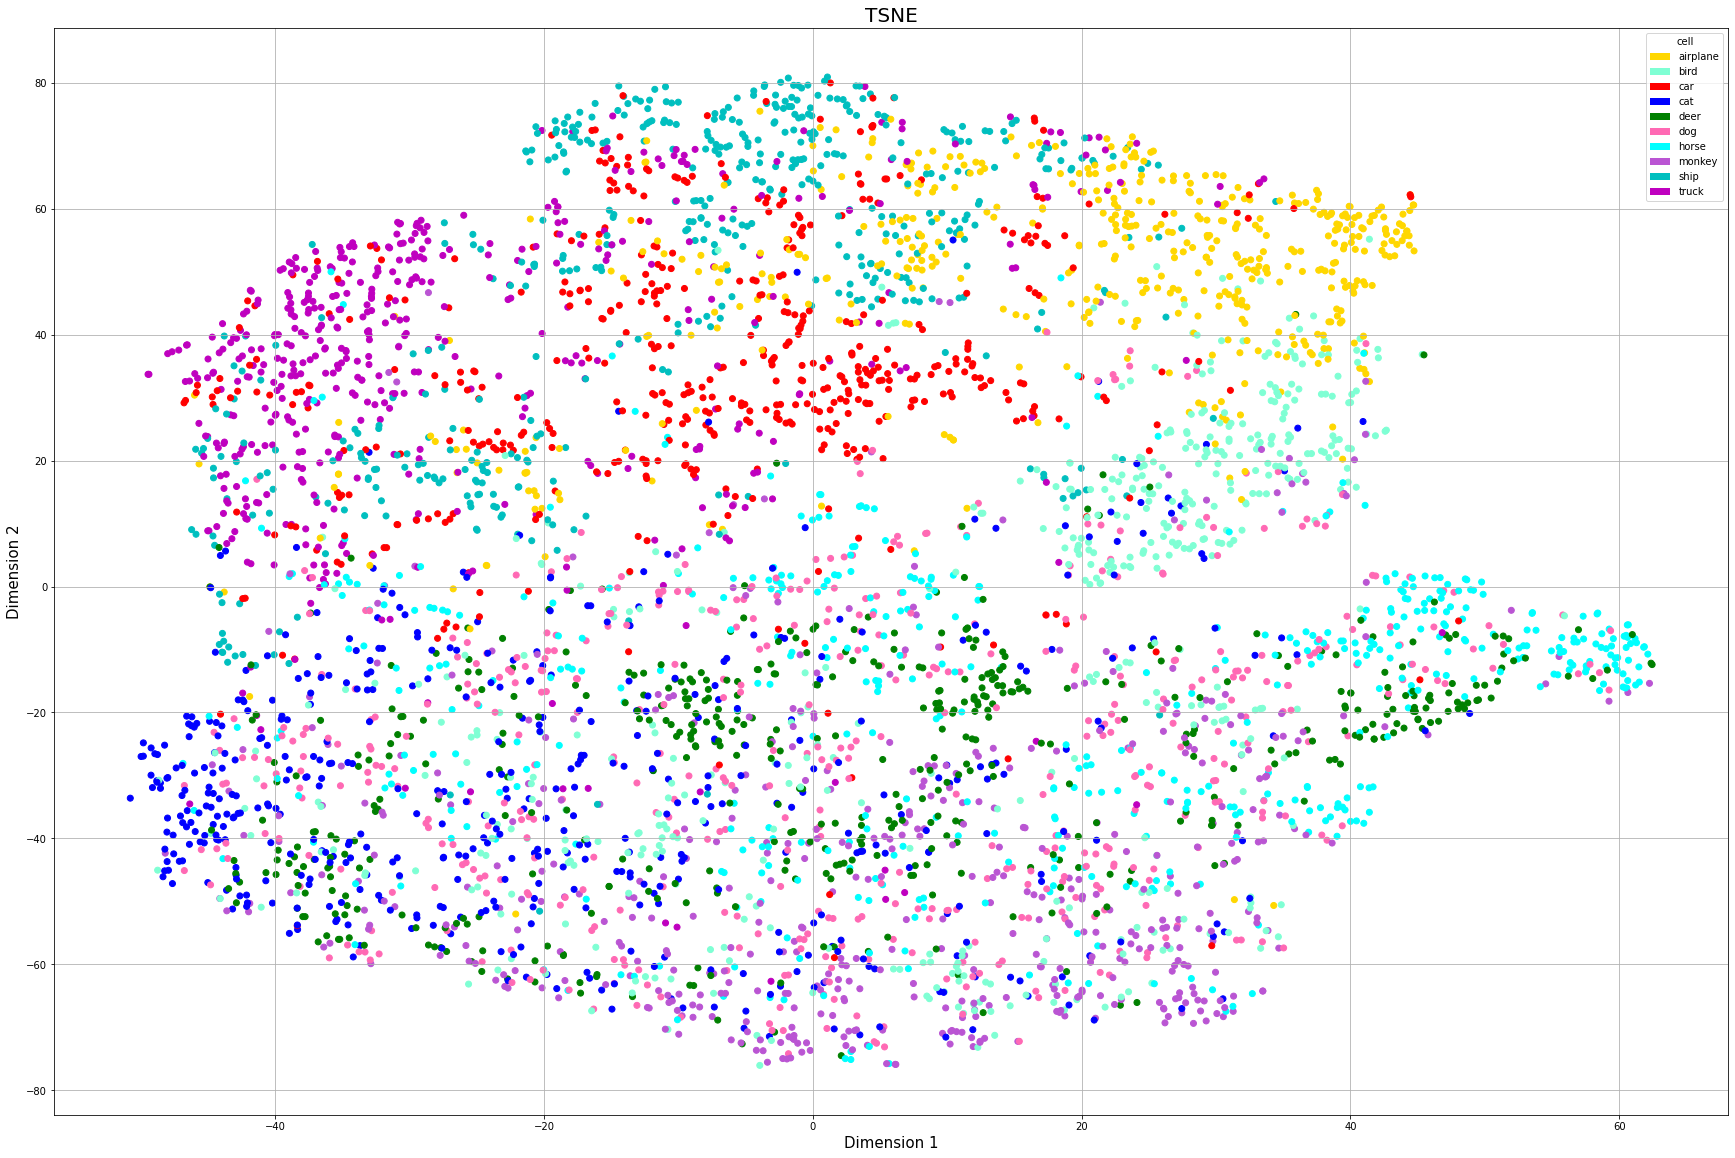

In [73]:
import matplotlib.patches as mpatches
colors = ['gold','aquamarine','r','b','g','hotpink','aqua','mediumorchid','c','m','y','k','lightcoral','royalblue','greenyellow']
cs_colors = [colors[labels[i]] for i in range(len(labels))]
ids = [0,1,2,3,4,5,6,7,8,9]
label_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(30)
ts = fig.add_subplot(1, 1, 1)
ts.set_xlabel('Dimension 1', fontsize = 15)
ts.set_ylabel('Dimension 2', fontsize = 15)
ts.set_title('TSNE', fontsize = 20)

ts.scatter(tsneDF['tsne dim 1'],
        tsneDF['tsne dim 2'], 
        c = cs_colors
        )
recs=[]
for i in range(len(colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
ts.legend(handles=recs, labels=label_names, title="cell")
ts.grid()
